## Import TensorFlow and other libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, ZeroPadding2D, UpSampling2D

from keras.models import Model
from keras import backend as K

from PIL import Image, ImageDraw
from random import seed
from random import random, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import random
import os


#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

In [4]:
print('Tensorflow Version : {}'.format(tf.__version__))
tf.random.set_seed(1305)

Tensorflow Version : 2.9.1


In [5]:
lreg=0.001
saveDir='DISCK_yes_hole_10_25_yes_w_yes_regul_de_l'+str(lreg)
save_model=False

In [6]:
generate_data=False
Hole_in_Training=True
weighted_pixel_loss=True
eucliden_term=True
latent_dim=1
alpha_w=1
h1=10
h2=25
l2= tf.keras.regularizers.l2(lreg)
re=None
rd=None
lambda_loss=0.1 # 1<lambda_loss<10

## Load the dataset

### Generate Disk Image DataSet


In [7]:
def loadImages(path):
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        with open(os.path.join(path, image), 'rb') as i:
            img = Image.open(i)
            loadedImages.append(np.array(img))
    return loadedImages

if generate_data:
    
        w, h = 64, 64 # Image Size

        #generate data for training

        num_images_train=20000
        radius_train=[]
        x_train =[]
        for i in range(num_images_train):
            value = uniform(0.1, 0.999)
            eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
            eX=round(eX,2)
            eY=eX
            radius_train.append(eX/2)    
            shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
            image = Image.new('L', (w, h), 'black')
            draw = ImageDraw.Draw(image)
            draw.ellipse(shape, fill = 'white', outline ='black')
            img_array=np.asarray(image)
            x_train.append(img_array)
            #image.save('disk_data/disk_data_train/disk'+str(i)+'.png')
        
        x_train = np.array(x_train)
        np.save('disk_data/disk_data_train/train.npy', x_train)
        df_train=pd.DataFrame(radius_train)
        df_train.to_csv('disk_data/radius_train.csv')

        #generate data for testing 

        num_images_test=2000
        radius_test=[]
        x_test= []
        for i in range(num_images_test):
            value = uniform(0.1, 0.999)
            eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
            eX=round(eX,2)
            eY=eX
            radius_test.append(eX/2)    
            shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
            image = Image.new('L', (w, h), 'black')
            draw = ImageDraw.Draw(image)
            draw.ellipse(shape, fill = 'white', outline ='black')
            img_array=np.asarray(image)
            x_test.append(img_array)
            #image.save('disk_data/disk_data_test/disk'+str(i)+'.png')

        x_test = np.array(x_test)
        np.save('disk_data/disk_data_test/test.npy', x_test)
        x_test1 = x_test
        df_test=pd.DataFrame(radius_test)
        df_test.to_csv('disk_data/radius_test.csv')
else:
    
    df_train=pd.read_csv('disk_data/radius_train.csv')
    df_test= pd.read_csv('disk_data/radius_test.csv')
    radius_train=df_train['0'].values
    radius_test=df_test['0'].values
    x_train=np.load('disk_data/disk_data_train/train.npy')
    x_test= np.load('disk_data/disk_data_test/test.npy')   
    w=x_train.shape[1]
    h=x_train.shape[2]

In [8]:
x_train.shape

(20000, 64, 64)

#### Distribution Test and Train Data

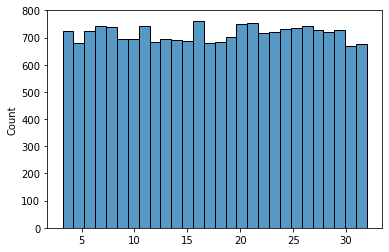

In [9]:
sns.histplot(data=radius_train)
#sns.histplot(data=radius_test)
#sns.histplot(data=r_train_h1_5)
plt.show()

### Guassian Blurring

In [10]:
# Blurring  5X5
# Blurring  5X5
x_train_blury = np.zeros((x_train.shape[0], 64, 64))
x_test_blury =  np.zeros((x_test.shape[0], 64, 64))
for i in range(x_train.shape[0]):
    x_train_blury[i] = cv2.GaussianBlur(x_train[i], (5, 5), 0)
for i in range(x_test.shape[0]):
    x_test_blury[i] =  cv2.GaussianBlur(x_test[i], (5, 5), 0)

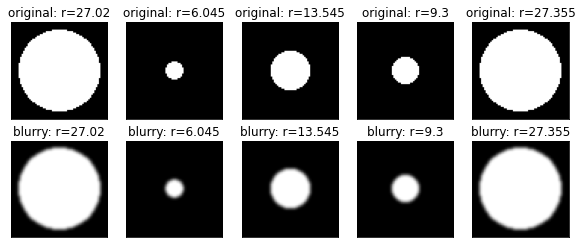

In [11]:
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_train_blury[i])
  plt.title("blurry: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [12]:

x_train_blury = x_train_blury.astype('float32') / 255.
x_test_blury  = x_test_blury.astype('float32') / 255.

print (x_train_blury.shape)
print (x_test_blury.shape)

(20000, 64, 64)
(2000, 64, 64)


# Convolutional autoencoder with bias

#### Encoder
The encoder part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (code_size).

We recommend to use activation='elu' for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), padding='same' and the following numbers of output channels: 32, 64, 128, 256.

Remember to flatten (L.Flatten()) output before adding the last dense layer!


#### Decoder
For decoder we will use so-called "transpose convolution".

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3.


Here's how "transpose convolution" works:  In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
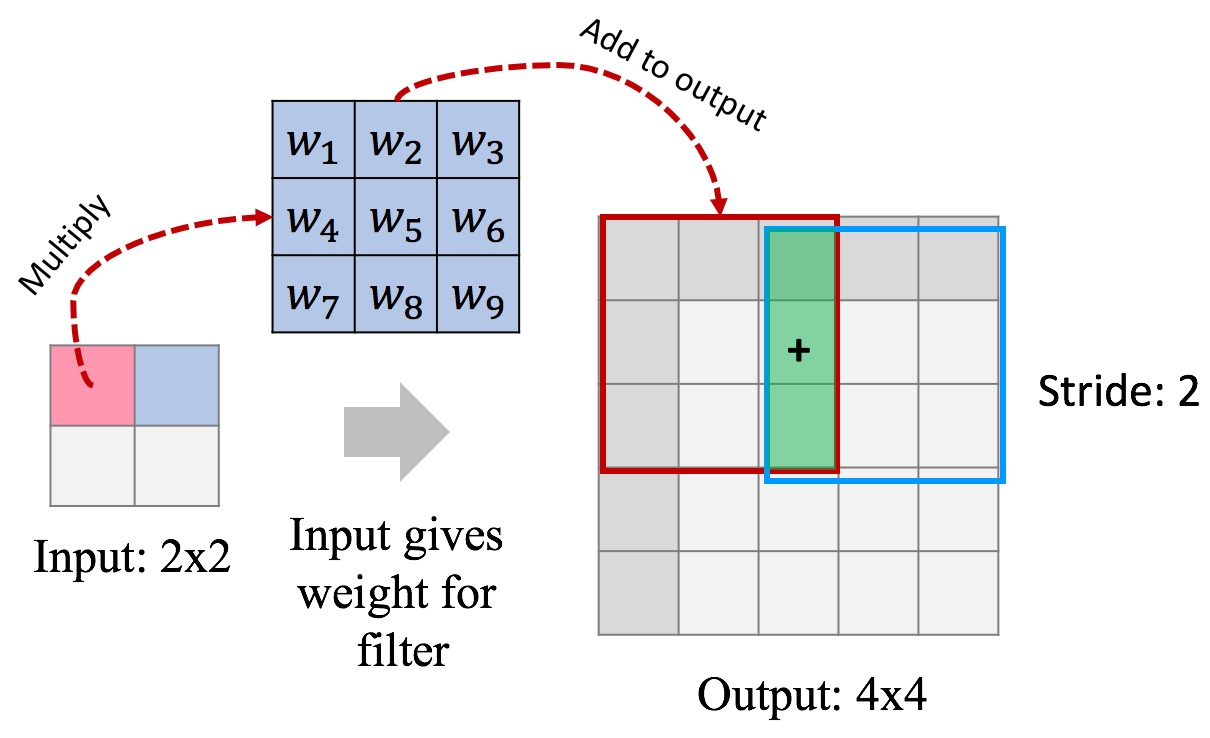

L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" L.Flatten() in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 L.Conv2DTranspose layers with the following numbers of output channels: 128, 64, 32, 3. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last L.Conv2DTranspose layer use activation=None because that is our final image.



In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

### Data Preparation for CNN Models

In [13]:
tf.keras.backend.clear_session()
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

In [14]:
num_epochs = 50
batch_size=64
verbose=1

In [15]:
# data prepration into CONV2D
x_train_blury_cnn=x_train_blury[..., np.newaxis]
x_test_blury_cnn=x_test_blury[..., np.newaxis]

In [16]:
print(' train shape dimension {}'.format(x_train_blury_cnn.shape))
print(' test shape dimension {}'.format(x_test_blury_cnn.shape))

 train shape dimension (20000, 64, 64, 1)
 test shape dimension (2000, 64, 64, 1)


In [17]:
print(' train min and max {}, {}'.format(x_train_blury_cnn.min(),x_train_blury_cnn.max()))
print(' test  min and max {}, {}'.format(x_test_blury_cnn.min(),x_test_blury_cnn.max()))

 train min and max 0.0, 1.0
 test  min and max 0.0, 1.0


### Ploting 

In [18]:
class plot_ae():
    def __init__(self, data, layer_name, encoder, decoder):
        self.data=data
        self.encoder=encoder
        self.decoder=decoder
        self.layer_name=layer_name
    
    def encode_predict(self):

        encode_model = Model(inputs= self.encoder.input,
                                  outputs=self.encoder.get_layer(self.layer_name).output)
         
        return encode_model.predict(self.data, batch_size=batch_size)
        
    def  decode_predict(self, x):
        decode_model = Model(inputs=self.decoder.input,
                                 outputs=self.decoder.output)
        return  decode_model.predict(x, batch_size=batch_size)
    
    def plot_reults(self, n, data, data_p, radius, latent, title):
        
        plt.figure(figsize=(20, 4))
        plt.suptitle(title)
        for i in range(n):
            img=random.randint(0, len(radius))

            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
    
    def plot_reults_hole(self, n, data, data_p, radius, latent, title, h1, h2, index=None):
        
        plt.figure(figsize=(20, 4))
        plt.suptitle(title)
        index_list=[]
        index_list1=[]
        for im in range(len(radius)):
            if radius[im]<=h2 and radius[im]>=h1:
                index_list.append(im)
            else:
                index_list1.append(im) 
                 
        if index:
            for i, img in enumerate(index):
                                # display original
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(data[img])
                plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # display reconstruction
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(data_p[img])
                plt.title("reconstructed")
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
        else:
            for i in range(n):        
                if i <6:
                    img=index_list1[random.randint(0, len(index_list1))]
                else:
                    img=index_list[random.randint(0, len(index_list))]
                            # display original
                print(img)
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(data[img])
                plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # display reconstruction
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(data_p[img])
                plt.title("reconstructed")
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        plt.savefig('fig/diks_interploationc.jpg', format='jpg')
        plt.show()
        
    def plot_reults_prof(self, n, data, data_p, radius, latent, title):
        
        plt.figure(figsize=(20, 6))
        plt.suptitle(title)
        for i in range(n):
            img=random.randint(0, n)
            # display original
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            t=np.arange(0,64)
            y= data[img][32]
            yp=data_p[img][32]
            ax = plt.subplot(3, n, i + 1 + n+n)
            plt.plot(t,y, label= 'Disk Profile')
            plt.plot(t,yp,label='Output Profile')
            plt.legend()
            
        plt.show()
        
    def plot_latent(self, data, latent, radius, title ):
        z=[]
        area =[]
        r=[]
        for i in range(data.shape[0]):
            z.append(latent[i][0][0][0])
            area.append((radius[i]*radius[i]*np.pi))
            r.append(radius[i])
            
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,4))
        fig.suptitle(title)
        axes[0].set_title('inspect the latent space vs radius')
        axes[1].set_title('inspect the latent space vs area')
        axes[0].set_xlabel('z, latent space')
        axes[1].set_xlabel('z, latent space')
        axes[0].set_ylabel('disk radius')
        axes[1].set_ylabel('disk area')
        sns.scatterplot(ax=axes[0], x=z, y=r)
        sns.scatterplot(ax=axes[1], x=z, y=area)
        plt.show()
        return z, r, area
        

In [19]:

activ=LeakyReLU(alpha=0.2)

code_size=1

inp=Input(shape=(64, 64,1), name='en1')

weights_tensor = Input(shape=(64, 64, 1), name='weights')
latent_tensor= layers.Input(shape=(1,), name='latent')
true = Input(shape=(64, 64, 1), name='true')

p=ZeroPadding2D( padding=(1, 1) )(inp)
cx=Conv2D(32*code_size, (3, 3), activation=activ, strides=2, name='en2', kernel_initializer='he_normal', kernel_regularizer=re) (p)
p=ZeroPadding2D( padding=(1, 1) )(cx)
cx=Conv2D(16*code_size, (3, 3), activation=activ, strides=2, name='en4', kernel_initializer='he_normal', kernel_regularizer=re)(p)
p=ZeroPadding2D( padding=(1, 1) )(cx)
cx=Conv2D(8*code_size, (3, 3), activation=activ, strides=2, name='en6', kernel_initializer='he_normal', kernel_regularizer=re) (p)
p=ZeroPadding2D( padding=(1, 1) )(cx)
cx=Conv2D(4*code_size, (3, 3), activation=activ, strides=2, name='en8', kernel_initializer='he_normal', kernel_regularizer=re) (p)
p=ZeroPadding2D( padding=(1, 1) ) (cx)
cx=Conv2D(2*code_size, (3, 3), activation=activ, strides=2, name='en10', kernel_initializer='he_normal',kernel_regularizer=re) (p)
p=ZeroPadding2D( padding=(1, 1) ) (cx)
cx=Conv2D(1*code_size, (3, 3), activation=activ, strides=2, name='en13', kernel_initializer='he_normal',kernel_regularizer=re) (p)

# Instantiate encoder
encoder = Model(inp, cx, name='encoder')


idd=UpSampling2D((2,2), name='de1') (cx)
cd=Conv2DTranspose(int(code_size*2),  kernel_size=3,activation=activ,name='de2', padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=rd) (idd)
ud=UpSampling2D((2,2), name='de3') (cd)
cd=Conv2DTranspose(code_size*4,  kernel_size=3,activation=activ,name='de4', padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=rd) (ud)
ud=UpSampling2D((2,2), name='de5') (cd)
cd=Conv2DTranspose(code_size*8,  kernel_size=3,activation=activ,name='de6', padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=rd) (ud)
ud=UpSampling2D((2,2), name='de7') (cd)
cd=Conv2DTranspose(code_size*8,  kernel_size=3,activation=activ,name='de8', padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=rd) (ud)
ud=UpSampling2D((2,2), name='de9') (cd)
cd=Conv2DTranspose(code_size*16, kernel_size=3,activation=activ, name='de10',padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=rd) (ud)
ud=UpSampling2D((2,2), name='de11') (cd)
cd=Conv2DTranspose(code_size*32, kernel_size=3,activation=activ, name='de12', padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=rd) (ud)
cd=Conv2D(1, kernel_size=3, activation='sigmoid', padding='same', name='de13', kernel_initializer='he_normal',
         kernel_regularizer=rd) (cd)

decoder = Model(cx, cd, name='decoder')


autoencoder_output = decoder(encoder(inp))
autoencoder        = Model([inp, true, weights_tensor], autoencoder_output, name='AE')
autoencoder.summary()


Model: "AE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 en1 (InputLayer)               [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 1, 1, 1)      6489        ['en1[0][0]']                    
                                                                                                  
 true (InputLayer)              [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 weights (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                 

In [20]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 en1 (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 66, 66, 1)        0         
 2D)                                                             
                                                                 
 en2 (Conv2D)                (None, 32, 32, 32)        320       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 34, 34, 32)       0         
 ng2D)                                                           
                                                                 
 en4 (Conv2D)                (None, 16, 16, 16)        4624      
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 18, 18, 16)       0   

## Training with whole

In [506]:
if Hole_in_Training:
    
        x_train_h=[]
        x_train_h_rad=[]
        for i in range(x_train_blury_cnn.shape[0]):
            if radius_train[i]>h2 or radius_train[i]<h1 :
                x_train_h.append(x_train_blury_cnn[i])
                x_train_h_rad.append(radius_train[i])
        x_train_h=np.array(x_train_h)
        x_train_blury_cnn = x_train_h
        radius_train= x_train_h_rad

In [507]:
print(np.max(radius_train), np.max(radius_test) )
print(np.min(radius_train), np.min(radius_test) )

31.965 31.95
3.2 3.2


In [508]:
treashhold=0.5
if weighted_pixel_loss:
    
    weight_img=[]
    for img in x_train_blury_cnn:
        nw, nb= 0, 0
        w=img.copy()
        w[w>=treashhold]=1
        w[w<treashhold]=0

        nw=np.sum(w==1) #white is one
        nb=np.sum(w==0) #black is zero
        
        w[w==1]=(nb**alpha_w)/(nb+nw) #white
        w[w==0]=nw/(nb+nw) #black
        weight_img.append(w)


    weight_img=np.array(weight_img)   
else:
    weight_img=np.ones_like(x_train_blury_cnn)

In [509]:
np.unique(weight_img[1])

array([0.02734375, 0.97265625], dtype=float32)

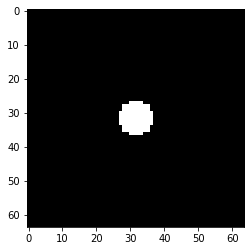

In [510]:
plt.imshow(weight_img[4])

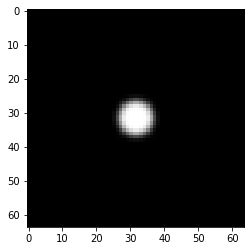

In [511]:
plt.imshow(x_train_blury_cnn[4])

In [512]:
def shape(tensor):
    """ get the shape of a tensor
    """
    s = tensor.get_shape()
    return tuple([s[i].value for i in range(0, len(s))])

def squared_dist(A):
    """
    Computes the pairwise distance between points
    #http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    """
    expanded_a = tf.expand_dims(A, 1)
    expanded_b = tf.expand_dims(A, 0)
    distances = tf.reduce_mean(tf.math.squared_difference(expanded_a, expanded_b), 2)
    return distances

def distance_loss(x, z_x):
    """ Loss based on the distance between elements in a batch
    """
    #z_x = tf.reshape(z_x, [shape(z_x)[0], np.prod(shape(z_x)[1:])])
    sdx = squared_dist(x)
    sdx = sdx/tf.reduce_mean(sdx)
    print(sdx.shape)
    sdz = squared_dist(z_x)
    sdz = sdz/tf.reduce_mean(sdz)
    return tf.reduce_mean(tf.square(tf.log(tf.constant(1.)+sdx) - (tf.log(tf.constant(1.)+sdz))))

In [513]:
x_train_tensor= tf.convert_to_tensor(x_train_blury_cnn)

In [514]:


def mmse_v0(y_true, y_pred, sample_weight, latent):
    #batch_size=list(range(len(y_true.get_shape())))
    #print(y_true.get_shape())
    #for ii in tf.range(batch_size[0]):
    #    print(ii)
    #print(batch_size)
    
    distances = []
    distances_ave= tf.zeros([1], tf.float32)
    distances_z= []
    distances_z_ave= tf.zeros([1], tf.float32)
    C=0
    for i in range(0, 64):
        for j in range(i + 1, 64):
            #A= tf.reduce_mean(tf.math.squared_difference(y_true[i] , y_true[j]))
            #B= latent[i]-latent[j]
            #print(A.shape)
            #print(B.shape)
                              
            distances.append(tf.reduce_mean(tf.math.squared_difference(y_true[i] , y_true[j])))
            distances_z.append (latent[i]-latent[j])
            
            C=C+tf.reduce_mean(tf.math.squared_difference(y_true[i], y_true[j]))
     
    for i in range(len(distances)):
        distances_ave=tf.math.add(distances_ave,distances[i])
        distances_z_ave=tf.math.add(distances_z_ave,distances_z[i])
        
    distances_ave=distances_ave/len(distances)
    distances_z_ave=distances_z_ave/len(distances)

    A=0
    for i in range(len(distances)):
        distances[i]=  tf.math.log(tf.constant(1.) + tf.math.divide(distances[i],distances_ave))
        distances_z[i]= tf.math.log(tf.constant(1.) + tf.math.divide(distances_z[i],distances_z_ave))
        A=A+tf.square(distances[i]-distances_z[i])
    
       
    loss1=  tf.reduce_mean(tf.math.multiply(tf.math.squared_difference(y_true, y_pred),sample_weight))
    
    loss2=  C#tf.reduce_mean(A)
    
    print(C.shape)
    
    loss= loss2 #+ loss2

    return loss

In [515]:
#https://github.com/jesse1029/Fake-Face-Images-Detection-Tensorflow/blob/1e545f3768cf3e8238c4076a9227089ca911ec6b/triplet_loss.py#L4


def mmse(y_true, y_pred, sample_weight, latent):

    #tile_1 = tf.tile(tf.expand_dims(x1, 0), [n, 1, 1, 1])
    #tile_2 = tf.tile(tf.expand_dims(x2, 1), [1, m, 1])
    #pairwise_euclidean_distance = tf.reduce_sum(tf.square(tf.subtract(tile_1, tile_2)), 2))
    
    #D=tf.reduce_sum((tf.expand_dims(y_true, 1)-tf.expand_dims(y_true, 0))**2,2)
    
    y=tf.squeeze(y_true, axis=3)
    shape = y.get_shape().as_list()
    dim = np.prod(shape[1:])
    y = tf.reshape(y, [-1, dim]) 
    dot_product = tf.matmul(y, tf.transpose(y))
    square_norm = tf.linalg.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
    distances = tf.maximum(distances, 0.0)
    distnaces_ave= tf.reduce_mean(distances)
    distances = distances / distnaces_ave
    distances = tf.math.log(tf.constant(1.) + distances)
    
    z=tf.squeeze(latent, axis=[2,3])
    dot_product_z = tf.matmul(z, tf.transpose(z))
    square_norm_z = tf.linalg.diag_part(dot_product_z)
    distances_z = tf.expand_dims(square_norm_z, 1) - 2.0 * dot_product_z + tf.expand_dims(square_norm_z, 0)
    distances_z = tf.maximum(distances_z, 0.0)
    distnaces_z_ave= tf.reduce_mean(distances_z)
    distances_z = distances_z / distnaces_z_ave
    distances_z = tf.math.log(tf.constant(1.) + distances_z)
    

    loss1=  tf.reduce_mean(tf.math.multiply(tf.math.squared_difference(y_true, y_pred),sample_weight))
    
    loss2=  tf.reduce_mean(tf.math.squared_difference(distances, distances_z))
    
    
    
    loss= loss1 + lambda_loss*loss2

    return loss

In [516]:
x = tf.constant([[1, 2, 3], [1, 1, 1], [2, 3, 5]]) # x.dtype is tf.int32
A=squared_dist(x_train_blury_cnn[0]).numpy()

In [517]:
A=tf.expand_dims(x_train_blury_cnn, 1)
A.shape

TensorShape([9563, 1, 64, 64, 1])

In [518]:
A=tf.math.reduce_euclidean_norm(x_train_blury_cnn[0:10], axis=None, keepdims=False, name=None).numpy()
A.shape

()

In [519]:
a = tf.constant([[1,2],[3,4]], tf.int32)
qexpand = tf.expand_dims(a,1) # one olumn                                                                                                         
qTexpand = tf.expand_dims(a,0) # one row  

In [520]:
a

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>

In [521]:
qexpand

<tf.Tensor: shape=(2, 1, 2), dtype=int32, numpy=
array([[[1, 2]],

       [[3, 4]]])>

In [522]:
qTexpand

<tf.Tensor: shape=(1, 2, 2), dtype=int32, numpy=
array([[[1, 2],
        [3, 4]]])>

In [523]:
qtile = tf.tile(qexpand,[1,2,1])                                                                                                                   
qTtile = tf.tile(qTexpand,[2,1,1]) 

In [524]:
qtile

<tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
array([[[1, 2],
        [1, 2]],

       [[3, 4],
        [3, 4]]])>

In [525]:
opti=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False )

#autoencoder.add_loss(mmse(true, autoencoder_output, weights_tensor))

autoencoder.add_loss( mmse( true, cd, weights_tensor, cx ) )

autoencoder.compile(optimizer=opti, loss=None)

es = EarlyStopping(monitor="val_loss", mode="min", verbose=verbose, patience=3)
mc = ModelCheckpoint( "model", monitor="val_loss", mode="max", verbose=verbose, save_best_only=True)



histh1_5=autoencoder.fit([x_train_blury_cnn, x_train_blury_cnn, weight_img ], x_train_blury_cnn,
                epochs=num_epochs,
                batch_size=batch_size,
                validation_split=0.2, callbacks=[es, mc], verbose=verbose)

Epoch 1/50
119/120 [============================>.] - ETA: 0s - loss: 0.0158
Epoch 1: val_loss improved from -inf to 0.00420, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


120/120 [==============================] - 6s 42ms/step - loss: 0.0157 - val_loss: 0.0042
Epoch 2/50
118/120 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 2: val_loss did not improve from 0.00420
120/120 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 3/50
118/120 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 3: val_loss did not improve from 0.00420
120/120 [==============================] - 2s 18ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/50
118/120 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 4: val_loss did not improve from 0.00420
120/120 [==============================] - 2s 17ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/50
119/120 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 5: val_loss did not improve from 0.00420
120/120 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/50
119/120 [============================>.] - 

In [526]:
autoencoder_final=Model(inputs=inp, outputs=autoencoder_output, name='AE-test')

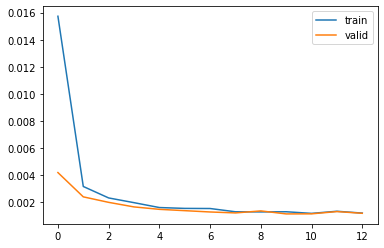

In [527]:
# Capturing learning history per epoch
hist = pd.DataFrame(histh1_5.history)
hist["epoch"] = histh1_5.epoch

# Plotting accuracy at different epochs
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(("train", "valid"), loc=0)

In [528]:
result_train_h=plot_ae(data=x_train_blury_cnn, layer_name='en13', encoder=encoder, decoder=decoder)
result_test_h =plot_ae(data=x_test_blury_cnn,  layer_name='en13', encoder=encoder, decoder=decoder )

In [529]:
encoded_imgs_train_h= result_train_h.encode_predict()
decoded_imgs_train_h= result_train_h.decode_predict(encoded_imgs_train_h)
decoded_imgs_train_h= decoded_imgs_train_h[:, :, :,0]

150/150 [==============================] - 1s 3ms/step


In [530]:
encoded_imgs_test_h=result_test_h.encode_predict()
decoded_imgs_test_h=result_test_h.decode_predict(encoded_imgs_test_h)
decoded_imgs_test_h=  decoded_imgs_test_h[:, :, :,0]

32/32 [==============================] - 0s 3ms/step


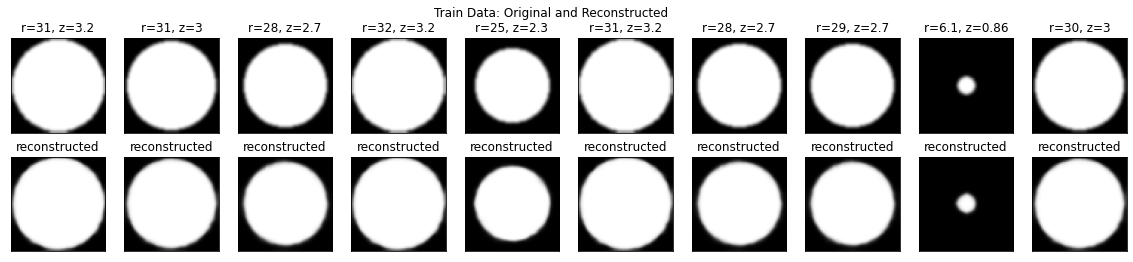

In [531]:
result_train_h.plot_reults(n=10, data=x_train_blury_cnn, data_p=decoded_imgs_train_h, radius=radius_train, 
                         latent=encoded_imgs_train_h, title='Train Data: Original and Reconstructed')

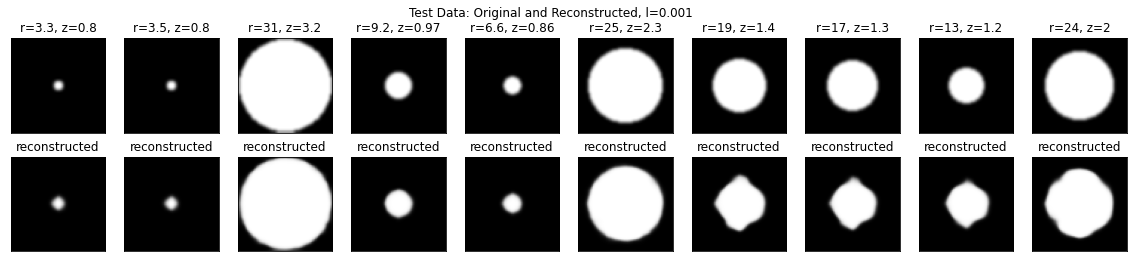

In [532]:
    index= [1443, 122, 1674, 364, 1706, 298, 125, 1496, 1507, 611]
result_test_h.plot_reults_hole(n=10, data=x_test_blury_cnn, data_p=decoded_imgs_test_h, radius=radius_test, 
                         latent=encoded_imgs_test_h, title='Test Data: Original and Reconstructed, l='+str(lreg), h1=h1, h2=h2, index=index)

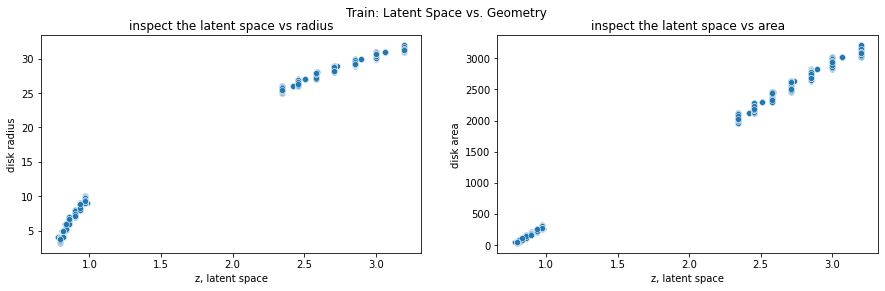

In [533]:
z_train_h1_5, r_train_h1_5, area_train_h1_5= result_train_h.plot_latent(data=x_train_blury_cnn, latent=encoded_imgs_train_h, radius=radius_train, 
                           title='Train: Latent Space vs. Geometry' )

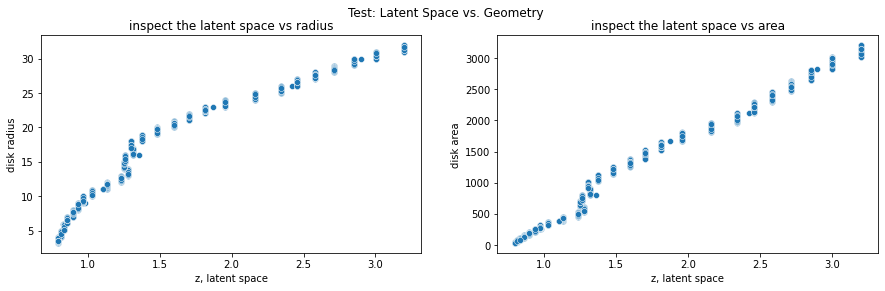

In [534]:
z_test_h1_5, r_test_h1_5, area_test_h1_5= result_test_h.plot_latent(data=x_test_blury_cnn, latent=encoded_imgs_test_h, 
                           radius=radius_test, title='Test: Latent Space vs. Geometry' )

In [535]:
z_s=[]
r_s=[]
for i in index[6:]:
    z_s.append(encoded_imgs_test_h[i][0][0][0])
    r_s.append(radius_test[i])

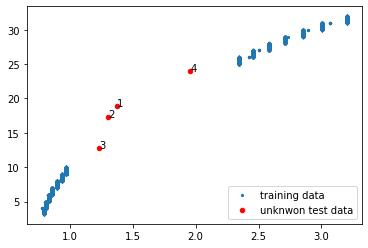

In [536]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(z_train_h1_5, r_train_h1_5,  s=5, label='training data')
ax1.scatter(z_s, r_s, s=20, color='red', label='unknwon test data')
for i, txt in enumerate(index[6:]):
    ax1.annotate(i+1, (z_s[i], r_s[i]))
    
#plt.title('2D latent manifold')
plt.legend(loc='lower right')
plt.savefig('fig/latent_disk2c.jpg', format='jpg')
plt.show()

In [537]:
latent_df_train= pd.DataFrame({'z':z_train_h1_5, 
                     'r': r_train_h1_5, 
                     'area':area_train_h1_5})

latent_df_test=pd.DataFrame({'z':z_test_h1_5, 
                     'r': r_test_h1_5, 
                     'area':area_test_h1_5})


In [538]:
if save_model:    
    autoencoder.save('Saved_Model\effect_regularization\model'+saveDir)
    hist.to_csv('Saved_Model\effect_regularization\hist'+saveDir+'.csv')
    latent_df_train.to_csv('Saved_Model\effect_regularization\latent_train'+saveDir+'.csv')
    latent_df_test.to_csv('Saved_Model\effect_regularization\latent_test'+saveDir+'.csv')
    

In [539]:
result_test= autoencoder_final.predict(x_test_blury_cnn)
result_train=autoencoder_final.predict(x_train_blury_cnn)

299/299 [==============================] - 1s 3ms/step


In [540]:
x_train_blury_cnn.shape

(9563, 64, 64, 1)

In [541]:
test_loss=True

In [542]:
if test_loss:
    
    decoded_imgs=decoded_imgs_train_h[..., np.newaxis]
    decoded_imgs=tf.convert_to_tensor(decoded_imgs)
    input_image= tf.convert_to_tensor(x_train_blury_cnn)
    weight_t= tf.convert_to_tensor(weight_img)
    latent_t= tf.convert_to_tensor(encoded_imgs_train_h)
    loss= mmse(input_image[100:101,:,:,:], decoded_imgs[100:101,:,:,:], weight_t[100:101,:,:,:], latent_t[100:101,:,:,:]).numpy() 
print(loss)

nan


In [543]:
y_true=decoded_imgs[6560:6563,:,:,:]
y=tf.squeeze(y_true, axis=3)
shape = y.get_shape().as_list()

dim = np.prod(shape[1:])
y = tf.reshape(y, [-1, dim]) 
dot_product = tf.matmul(y, tf.transpose(y))
square_norm = tf.linalg.diag_part(dot_product)
distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
distances = tf.maximum(distances, 0.0)
distnaces_ave= tf.reduce_mean(distances)
distances = distances / distnaces_ave
distances = tf.math.log(tf.constant(1.) + distances)

z=tf.squeeze(latent_t[6560:6563,:,:,:], axis=[2,3])
dot_product_z = tf.matmul(z, tf.transpose(z))
square_norm_z = tf.linalg.diag_part(dot_product_z)
distances_z = tf.expand_dims(square_norm_z, 1) - 2.0 * dot_product_z + tf.expand_dims(square_norm_z, 0)
distances_z = tf.maximum(distances_z, 0.0)
distnaces_z_ave= tf.reduce_mean(distances_z)
distances_z = distances_z / distnaces_z_ave
distances_z = tf.math.log(tf.constant(1.) + distances_z)

In [544]:
distances.numpy()

array([[0.        , 1.1465505 , 0.03956048],
       [1.1465505 , 0.        , 1.1976516 ],
       [0.03956048, 1.1976516 , 0.        ]], dtype=float32)

In [545]:
distances_z

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.        , 1.1228151 , 0.01282515],
       [1.1228151 , 0.        , 1.2277668 ],
       [0.01282515, 1.2277668 , 0.        ]], dtype=float32)>

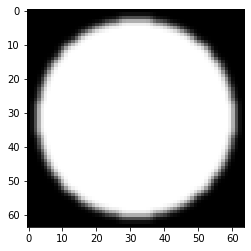

In [546]:
plt.imshow(x_train_blury_cnn[6560])

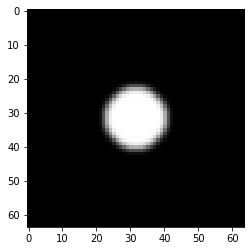

In [547]:
plt.imshow(x_train_blury_cnn[6561])

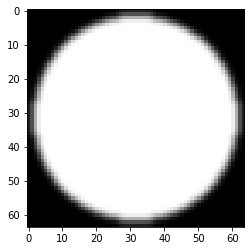

In [548]:
plt.imshow(x_train_blury_cnn[6562])

In [549]:
z1_test_dist=latent_t[6560:6563,:,:,0].numpy()
print(z1_test_dist)

[[[2.8523605]]

 [[0.9703602]]

 [[3.0001903]]]


In [550]:
d_z=[]
d_z_ave=0
for i in range(3):
    for j in range(i+1,3):
        print(i,j)
        a=np.sqrt((z1_test_dist[i][0][0]-z1_test_dist[j][0][0])**2+ (z2_test_dist[i][0][0]-z2_test_dist[j][0][0])**2)
        d_z.append(a)
        d_z_ave+=a
d_z=d_z/a

0 1


NameError: name 'z2_test_dist' is not defined

In [ ]:

d_z


### 